# Mathématiques

On a $a>0$ et $b>|d|>0$ et on définit la fonction d'utilité par:

\begin{equation}
    \forall (q_0, q_1, q_2) \in \mathbb{R}^3,\quad U(q_0, q_1, q_2):= q_0 + a (q_1 + q_2) - \frac{bq_1^2+bq_2^2+2dq_1q_2}{2}.
\end{equation}

On se donne également $p_1,p_2,R >0$ et on introduit le domaine de contrainte

\begin{equation}
T:=\{(q_0, q_1, q_2)\in \mathbb{R}^3\ :\ q_0 \geq 0,\ q_1\geq 0,\ q_2 \geq 0,\ q_0 + p_1 q_1 + p_2 q_2 \leq R\}
\end{equation}

On définit alors

$$
(\tilde{q_0}(p_1, p_2), \tilde{q_1}(p_1, p_2), \tilde{q_2}(p_1, p_2)) := \underset{(q_0, q_1, q_2)\in T}{\mathrm{argmax}} U(q_0, q_1, q_2)
$$

On voit facilement qu'on peut en fait se ramener au problème 
$$
\forall (q_1, q_2)\in \mathbb{R}^2,\qquad V(q_1, q_2):= R + (a - p_1) q_1 + (a - p_2) q_2 - \frac{b q_1^2+b q_2^2+2 d q_1 q_2}{2}.
$$
Que l'on maximise sur le domaine
$$
S:=\{(q_1, q_2)\in \mathbb{R}^2\ :\ q_1\geq 0,\ q_2 \geq 0,\ p_1 q_1 + p_2 q_2 \leq R\},
$$

# Imports

In [3]:
from IPython.display import display

In [1]:
import sympy as sp
sp.init_printing()

In [29]:
from dataclasses import dataclass

In [32]:
import numpy as np

In [28]:
import plotly.graph_objects as go

In [70]:
import dash
from dash import dcc
from dash import html
from jupyter_dash import JupyterDash

# Définition des objets

In [5]:
q1, q2 = sp.symbols("q_1 q_2")
a, b, d, R = sp.symbols("a b d R")
p1, p2 = sp.symbols("p_1 p_2")

In [6]:
V = (a - p1) * q1 + (a - p2) * q2 - (b * q1 ** 2 + b * q2 ** 2 + 2 * d * q1 * q2) / 2
display(V)

# Existence et Concavité

In [11]:
H = sp.hessian(V, [q1, q2])
display(H)

⎡-b  -d⎤
⎢      ⎥
⎣-d  -b⎦

In [12]:
H.eigenvals()

On voit donc bien que sous l'hypothèse $0< |d| < b$ on a stricte concavité de $V$.

De plus, le domaine $S$ est compact car $p_1$, $p_2$ et $R$ sont positifs (et donc $0\leq q_1 \geq \frac{R}{p_1}$ et $0 \leq q_2 \geq \frac{R}{p_2}$).

On en conclu que le programme admet un unique maximiseur.

# Calcul du point critique

In [7]:
equations = [
    sp.Eq(V.diff(q1), 0),
    sp.Eq(V.diff(q2), 0),
]
display(equations)

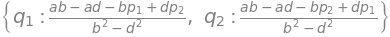

In [8]:
solutions = sp.solve(equations, (q1, q2))
display(solutions)

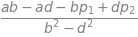

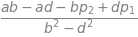

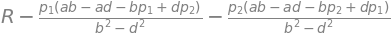

In [25]:
q1s, q2s = solutions[q1], solutions[q2]
contrainte = R - p1 * q1s - p2 * q2s
display(q1s, q2s, contrainte)

In [21]:
sp.solve(q1s.subs(p2, 0), p1)

In [22]:
sp.solve(q1s.subs(p1, 0), p2)

In [23]:
sp.solve(q2s.subs(p1, 0), p2)

In [24]:
sp.solve(q2s.subs(p2, 0), p1)

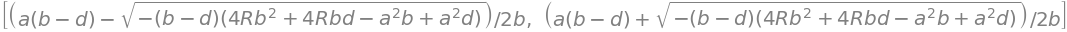

In [26]:
sp.solve(contrainte.subs(p2, 0), p1)

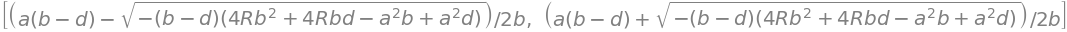

In [27]:
sp.solve(contrainte.subs(p1, 0), p2)

# Visualisation

Ensemble de niveaux de $V$ en fonction des paramètres.

In [95]:
@dataclass
class Visualisation:
    a: float = 1.5
    b: float = 2.
    d: float = 1.
    R: float = 10.
    p1: float = 1.1
    p2: float = 1.1
    
    def __post_init__(self):
        self.gen_figure()
    
    def _calcule_valeurs(self):
        alpha = np.linspace(0, 1, 100)
        theta = np.linspace(0, 1, 100)
        A, T = np.meshgrid(alpha, theta)
        Q1 = A * self.R / self.p1
        Q2 = (1 - A) * T * self.R / self.p2
        V = (
            self.R 
            + Q1 * (self.a - self.p1) 
            + Q2 * (self.a - self.p2) 
            - (self.b * Q1 ** 2 + self.b * Q2 ** 2 + 2 * self.d * Q1 * Q2) / 2
        )
        return Q1, Q2, V
    
    def _genere_surface(self):
        Q1, Q2, V = self._calcule_valeurs()
        return go.Surface(x=Q1, y=Q2, z=V)
    
    def gen_figure(self):
        surface = self._genere_surface()
        self.figure = go.Figure(
                data=[surface],
                layout=dict(width=600, height=600, transition_duration=500, uirevision="pas_touche"),
            )
        return self.figure
        

In [96]:
app = JupyterDash(__name__) # à modifier par dash.App si à l'extérieur d'un notebook
vis = Visualisation()
app.layout = html.Div([
    html.H1("Programme du consommateur."),
    html.Div("",id="deboguage"),
    html.Div(str(vis), id="vis"),
    html.Label(["a", dcc.Slider("slider_a", min=0.5, max=10., step=0.5, value=vis.a)]),
    dcc.Graph(id="figure"),
])

@app.callback(
    [
        dash.dependencies.Output("vis", "children"),
        dash.dependencies.Output('figure', 'figure'),
    ],
    [
        dash.dependencies.Input("slider_a", "value"),
    ]
)
def maj_donnees(a):
    vis.a = a
    return str(vis), vis.gen_figure() 

    
app.run_server(mode="inline")